**BIL 468 Homework**  
Deadline: April 13, 23:59

In this assignment, you are going to train CNN classifiers using Early Stopping on a subset of CIFAR100 dataset. You can include additional methods, layers, options, etc. in order to improve the performance of CNN classifiers. However, **you cannot modify test set**. For example, you can use data augmentation only while training. Also, do not change validation set split method. You are going to train 2 different CNN model:  
- CNN with 4 Conv2D layers (number_convolution_layer = 4)  
- CNN with 6 Conv2D layers (number_convolution_layer = 6)


You are allowed to change any other specifications of the models. For each model:  
- Change student_no with your student ID  
- Set number_convolution_layer to number of Conv2D layers  
- Save the notebook you use to train the model (e.g. CNN_studentID_4.ipynb)  
- Save the final model (e.g. CNN_studentID_4.h5)  
- Run the notebook after training and make sure it works and shows test results correctly

Note that, the notebook saves the best model at the end of the training. If you run the notebook after training, it loads the earlier model and skips the training. If you want to train a different model, you can simply delete or change the name of the earlier saved model. This folder stores an example for a CNN model with 2 Conv2D layers (.h5 and .ipynb files). Upload resulting 2 .h5 files and 2 .ipynb files to UZAK. You are going to be graded on the design details of the models such as performance, originality, architecture, hyperparameter configuration.

For Cifar100 dataset: https://keras.io/api/datasets/cifar100/  
For Keras deep learning library,  
Getting started: https://keras.io/getting_started/intro_to_keras_for_engineers/  
Documentation: https://keras.io/2.16/api/  

In [558]:
# Change parameters for model save name
number_convolution_layer = 4
student_no = 191401009

In [559]:
# Do not change this part
# Sets model save name
model_path = './CNN_' + str(student_no)  + '_' + str(number_convolution_layer) + '.h5'

In [560]:
# Includes libraries
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, GlorotUniform
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.config import list_physical_devices
list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [561]:
# Do not change this part
# Loads data
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='coarse')
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(set(list(y_train[:,0])))

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [562]:
# Do not change this part
# Removes unused data
relevant_classes = [0, 1, 7, 8, 11, 12, 13, 14, 15, 16]
k = 0
for i in range(20):
    if i in relevant_classes:
        y_train[y_train == i] = k
        y_test[y_test == i] = k
        k = k + 1
    else:
        locations = y_train[:,0] == i
        y_train = np.delete(y_train, locations, axis=0)
        x_train = np.delete(x_train, locations, axis=0)
        locations = y_test[:,0] == i
        y_test = np.delete(y_test, locations, axis=0)
        x_test = np.delete(x_test, locations, axis=0)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(set(list(y_train[:,0])))

(25000, 32, 32, 3) (25000, 1)
(5000, 32, 32, 3) (5000, 1)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [563]:
# Do not change this part
# Creates train, val (validation) and test sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(20000, 32, 32, 3) (20000, 1)
(5000, 32, 32, 3) (5000, 1)
(5000, 32, 32, 3) (5000, 1)


In [564]:
# Do not change this part
# labels are class names
# We have 10 classes
labels = ['aquatic_mammals', 'fish', 'insects', 'large_carnivores',
          'large_omnivores_herbivores', 'medium_mammals',
          'noninsect_invertebrates', 'people', 'reptiles', 'small_mammals']

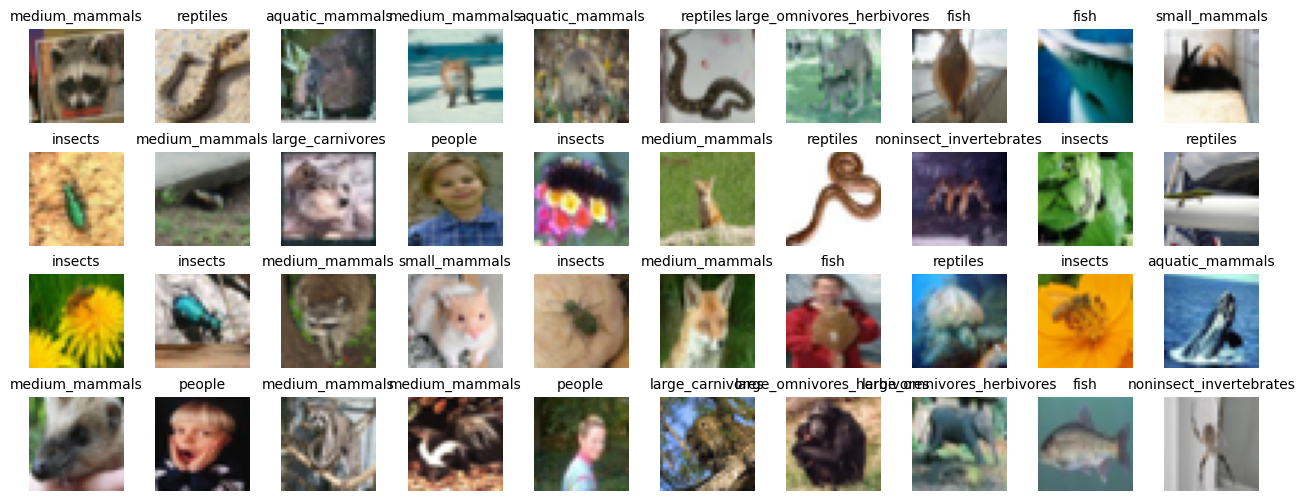

In [565]:
# Displays random images from train set
a, b = 4, 10
fig, axes = plt.subplots(a, b, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, a*b):
    index = np.random.randint(x_train.shape[0])
    axes[i].imshow(x_train[index, :, :, :])
    axes[i].set_title(labels[int(y_train[index, 0])], fontsize=10)
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)

In [566]:
from tensorflow.keras.layers import LayerNormalization
# CNN model
def CNN(image):
    x = BatchNormalization()(image)
    x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(x) #LAYER1
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu')(x) #LAYER2
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu')(x) #LAYER3
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = Conv2D(filters=1024, kernel_size=(1, 1), strides=(1, 1), activation='tanh')(x) #LAYER4
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=10, activation='softmax')(x)
    return x

In [567]:
# Model initialization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

input_shape = Input((32, 32, 3))
model = Model(input_shape, CNN(input_shape))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization_131 (Ba  (None, 32, 32, 3)        12        
 tchNormalization)                                               
                                                                 
 conv2d_140 (Conv2D)         (None, 32, 32, 128)       9728      
                                                                 
 batch_normalization_132 (Ba  (None, 32, 32, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_105 (MaxPooli  (None, 16, 16, 128)      0         
 ng2D)                                                           
                                                          

In [568]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', threshold=0.60):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_val_accuracy = logs.get(self.monitor)
        if current_val_accuracy is not None:
            if current_val_accuracy > self.threshold:
                print(f'\nEpoch {epoch + 1}: Reached {self.threshold * 100}% validation accuracy. Stopping training...')
                self.model.stop_training = True


custom_early_stopping = CustomEarlyStopping(monitor='val_accuracy', threshold=0.70)

In [569]:
# Data augmentation for train set
datagen = ImageDataGenerator(   
                             rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=[1, 1.25],
                             horizontal_flip=True,
                                vertical_flip=True,
                             fill_mode='reflect',
                             )
datagen.fit(x_train)

In [570]:
# Model training

callbacks = [
    custom_early_stopping,
    ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)
]

try:
    model.load_weights(model_path)
    print('Model is loaded.')
except:
    print('Training starts...')
    batch_size = 128
    steps_per_epoch = len(x_train) // batch_size
    early_stopping = [EarlyStopping(monitor='val_loss', patience=50),
                      ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=False)]
    history = model.fit(datagen.flow(x_train, y_train_onehot, batch_size=batch_size),
                                  epochs=300,
                                  steps_per_epoch= steps_per_epoch,
                                  validation_data=(x_val, y_val_onehot),
                                  callbacks=[callbacks],
                                  validation_steps= len(x_val) // batch_size,
                                  shuffle=False,
                                  verbose=1)
    model.save(model_path)
    model.load_weights(model_path)

Training starts...
Epoch 1/300
156/156 [==============================] - 8s 44ms/step - loss: 2.2751 - accuracy: 0.1879 - val_loss: 2.3543 - val_accuracy: 0.1000
Epoch 2/300
156/156 [==============================] - 7s 42ms/step - loss: 2.1140 - accuracy: 0.2337 - val_loss: 2.2234 - val_accuracy: 0.1736
Epoch 3/300
156/156 [==============================] - 6s 40ms/step - loss: 2.0581 - accuracy: 0.2586 - val_loss: 2.0229 - val_accuracy: 0.2780
Epoch 4/300
156/156 [==============================] - 6s 40ms/step - loss: 2.0211 - accuracy: 0.2746 - val_loss: 1.9803 - val_accuracy: 0.2984
Epoch 5/300
156/156 [==============================] - 6s 39ms/step - loss: 1.9946 - accuracy: 0.2878 - val_loss: 1.9969 - val_accuracy: 0.2800
Epoch 6/300
156/156 [==============================] - 6s 41ms/step - loss: 1.9723 - accuracy: 0.3011 - val_loss: 1.9189 - val_accuracy: 0.3264
Epoch 7/300
156/156 [==============================] - 6s 41ms/step - loss: 1.9545 - accuracy: 0.3076 - val_loss: 1.8

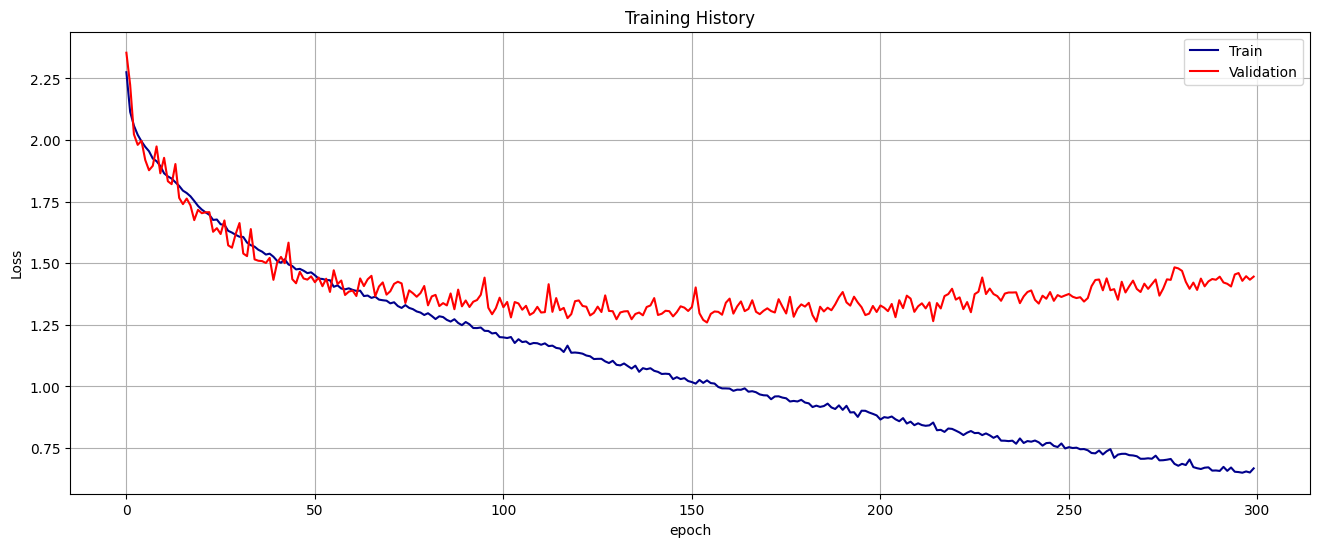

In [571]:
# Plots training history
try:
    plt.subplots(figsize=(16,6))
    plt.plot(history.history['loss'], color='darkblue', linewidth=1.5, label='Train')
    plt.plot(history.history['val_loss'], color='red', linewidth=1.5, label='Validation')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
except:
    pass

In [572]:
# Test performance
probs_test = model.predict(x_test)
preds_test = np.argmax(probs_test, axis=1)
print('Accuracy: {:.4}'.format(accuracy_score(y_test, preds_test)))
print('F1-score: {:.4}'.format(f1_score(y_test, preds_test, average='weighted')))
print(classification_report(y_test, preds_test, target_names=labels))

157/157 [==============================] - 0s 2ms/step
Accuracy: 0.6002
F1-score: 0.6012
                            precision    recall  f1-score   support

           aquatic_mammals       0.58      0.51      0.54       500
                      fish       0.69      0.60      0.64       500
                   insects       0.74      0.67      0.71       500
          large_carnivores       0.54      0.65      0.59       500
large_omnivores_herbivores       0.62      0.52      0.57       500
            medium_mammals       0.50      0.63      0.55       500
   noninsect_invertebrates       0.59      0.60      0.59       500
                    people       0.81      0.81      0.81       500
                  reptiles       0.47      0.51      0.48       500
             small_mammals       0.55      0.50      0.52       500

                  accuracy                           0.60      5000
                 macro avg       0.61      0.60      0.60      5000
              weighted av

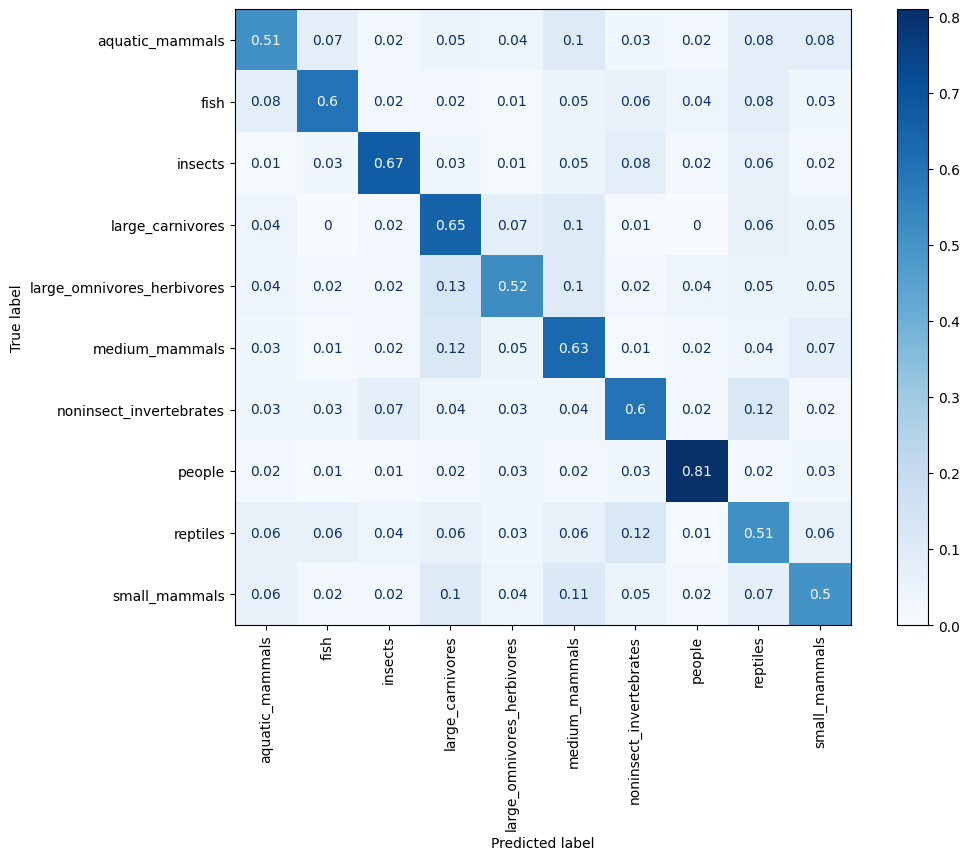

In [573]:
# Confusion matrix
CM = np.round(confusion_matrix(y_test, preds_test, normalize='true'), 2)
CMD = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,8))
CMD.plot(xticks_rotation='vertical', ax=ax, cmap='Blues')
plt.show()

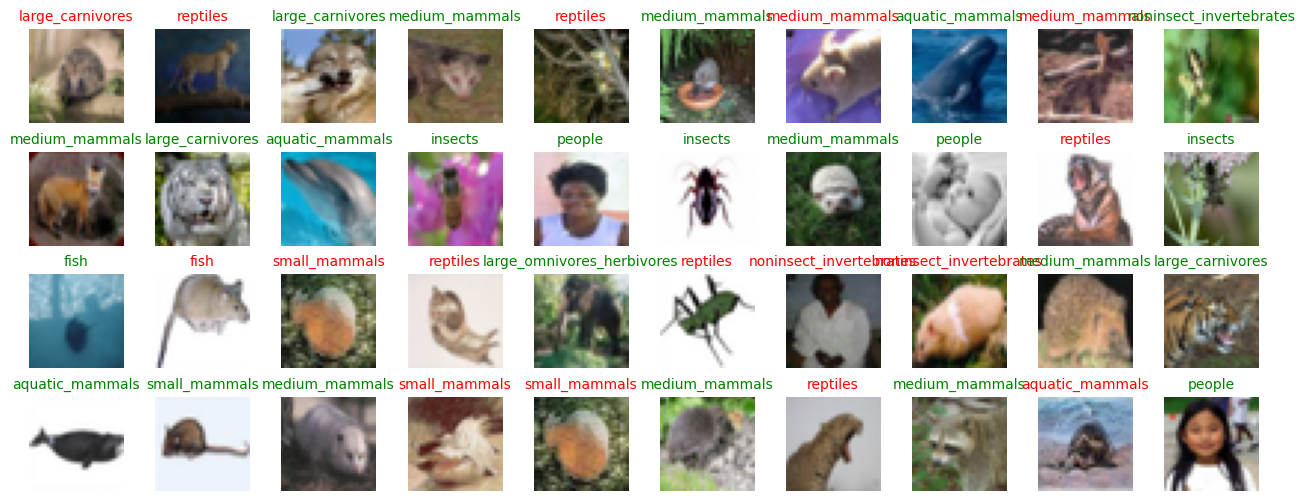

In [574]:
# Displays random image predictions from test set
a, b = 4, 10
fig, axes = plt.subplots(a, b, figsize = (16,6))
axes = axes.ravel()
for i in np.arange(0, a*b):
    index = np.random.randint(x_test.shape[0])
    axes[i].imshow(x_test[index, :, :, :])
    if preds_test[index] == int(y_test[index, 0]):
        axes[i].set_title(labels[preds_test[index]], fontsize=10, color='green')
    else:
        axes[i].set_title(labels[preds_test[index]], fontsize=10, color='red')
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.3)